In [170]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy import random
from numpy.fft import fft, fftshift
import statistics 
import h5py
from scipy.optimize import curve_fit
from scipy.signal import welch
# from qiskit.visualization import array_to_latex
import h5py

from experiments.single_qubit.single_shot import hist 


In [171]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy import random
from numpy.fft import fft, fftshift
import statistics 
import h5py
from scipy.optimize import curve_fit
from scipy.signal import welch

# Load the Data

In [172]:
def load_dataset(dataset_path):
    datasets = {}
    with h5py.File(dataset_path, 'r') as file:
        for key in file.keys():
            datasets[key] = np.array(file[key][...])
    return datasets

# Specify the dataset path
dataset_path = "C:\\_Lib\\python\\rfsoc\\elaine_rfsoc\\slab_rfsoc_expts\\data\\00032_single_shot_qubit0.h5"

# Load dataset
datasets = load_dataset(dataset_path)

# Access each dataset by its key
for key, value in datasets.items():
    print("Key:", key)

Ie = datasets["Ie"]
Ig = datasets["Ig"]
Qe = datasets["Qe"]
Qg = datasets["Qg"]

Key: Ie
Key: Ig
Key: Qe
Key: Qg


# Histogram the Data

Unrotated:
Ig 2.7744630071599046 +/- 3.9892820575432664 	 Qg 1.5557604686482969 +/- 4.022631028557671 	 Amp g 3.1808859793943496
Ie 13.296159687567801 +/- 4.943436381331237 	 Qe -9.767520069429377 +/- 5.013499150868548 	 Amp e 16.498251748109823


Rotated:
Ig 0.7188279146511164 +/- 3.9892820575432664 	 Qg 3.0992764725947133 +/- 4.022631028557671 	 Amp g 3.1815449430207337
Ie 16.392900756042707 +/- 4.943436381331237 	 Qe 3.1022159700572205 +/- 5.013499150868548 	 Amp e 16.683852646266793


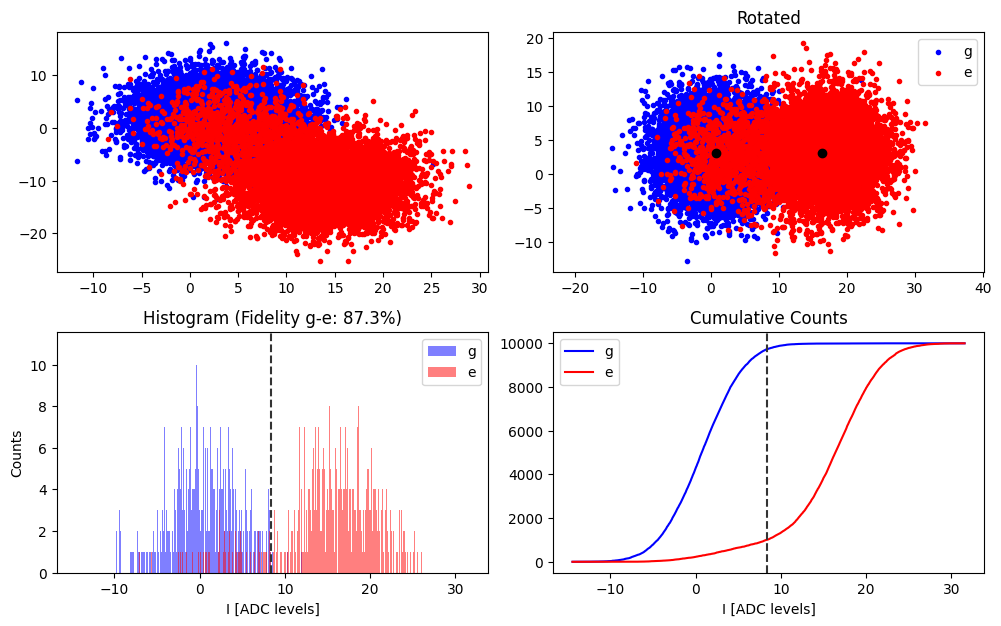

ge fidelity 87.3%
rotation angle 47.101479665755235 (deg)
ge threshold 8.390387956818572


In [286]:
numbins = 10000
xg, yg = np.median(Ig), np.median(Qg)
xe, ye = np.median(Ie), np.median(Qe)

print('Unrotated:')
print(f'Ig {xg} +/- {np.std(Ig)} \t Qg {yg} +/- {np.std(Qg)} \t Amp g {np.abs(xg+1j*yg)}')
print(f'Ie {xe} +/- {np.std(Ie)} \t Qe {ye} +/- {np.std(Qe)} \t Amp e {np.abs(xe+1j*ye)}')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
fig.tight_layout()

axs[0,0].scatter(Ig, Qg, label='g', color='b', marker='.')
axs[0,0].scatter(Ie, Qe, label='e', color='r', marker='.')


"""Compute the rotation angle"""
theta = -np.arctan2((ye-yg),(xe-xg))

"""Rotate the IQ data"""
Ig_new = Ig*np.cos(theta) - Qg*np.sin(theta)
Qg_new = Ig*np.sin(theta) + Qg*np.cos(theta) 

Ie_new = Ie*np.cos(theta) - Qe*np.sin(theta)
Qe_new = Ie*np.sin(theta) + Qe*np.cos(theta)

"""New means of each blob"""
xg, yg = np.median(Ig_new), np.median(Qg_new)
xe, ye = np.median(Ie_new), np.median(Qe_new)

print('Rotated:')
print(f'Ig {xg} +/- {np.std(Ig)} \t Qg {yg} +/- {np.std(Qg)} \t Amp g {np.abs(xg+1j*yg)}')
print(f'Ie {xe} +/- {np.std(Ie)} \t Qe {ye} +/- {np.std(Qe)} \t Amp e {np.abs(xe+1j*ye)}')

span = (np.max(np.concatenate((Ie_new, Ig_new))) - np.min(np.concatenate((Ie_new, Ig_new))))/2
xlims = [(xg+xe)/2-span, (xg+xe)/2+span]
ylims = [yg-span, yg+span]

axs[0,1].scatter(Ig_new, Qg_new, label='g', color='b', marker='.')
axs[0,1].scatter(Ie_new, Qe_new, label='e', color='r', marker='.')
axs[0,1].scatter(xg, yg, color='k', marker='o')
axs[0,1].scatter(xe, ye, color='k', marker='o')    

# axs[0,1].set_xlabel('I [ADC levels]')
axs[0,1].legend(loc='upper right')
axs[0,1].set_title('Rotated')
axs[0,1].axis('equal')

"""X and Y ranges for histogram"""

ng, binsg, pg = axs[1,0].hist(Ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
ne, binse, pe = axs[1,0].hist(Ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)

axs[1,0].set_ylabel('Counts')
axs[1,0].set_xlabel('I [ADC levels]')       
axs[1,0].legend(loc='upper right')

"""Compute the fidelity using overlap of the histograms"""
fids = []
thresholds = []
contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum())))
tind=contrast.argmax()
thresholds.append(binsg[tind])
fids.append(contrast[tind])

    
axs[1,0].set_title(f'Histogram (Fidelity g-e: {100*fids[0]:.3}%)')
axs[1,0].axvline(thresholds[0], color='0.2', linestyle='--')

axs[1,1].set_title('Cumulative Counts')
axs[1,1].plot(binsg[:-1], np.cumsum(ng), 'b', label='g')
axs[1,1].plot(binse[:-1], np.cumsum(ne), 'r', label='e')
axs[1,1].axvline(thresholds[0], color='0.2', linestyle='--')

axs[1,1].legend()
axs[1,1].set_xlabel('I [ADC levels]')

plt.subplots_adjust(hspace=0.25, wspace=0.15)        
plt.show()


print(f'ge fidelity {100*fids[0]:.3}%' )
print(f'rotation angle {theta*180/np.pi} (deg)')
print(f'ge threshold {thresholds[0]}')

<BarContainer object of 200 artists>


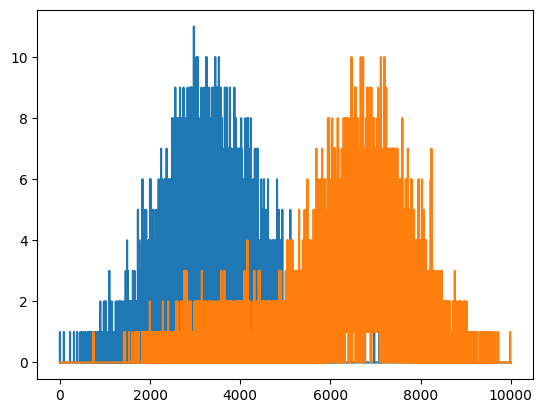

In [287]:
plt.plot(ng)
plt.plot(ne)



# Confusion Matrix 

Filter the data

In [288]:
def filter_values_less_than_threshold(array, threshold):
    # Find indices of values less than the threshold
    indicies = np.where(array < threshold)
    
    # Extract values less than the threshold
    values_less_than_threshold = array[indicies]
    
    return values_less_than_threshold

def filter_values_greater_than_threshold(array, threshold):
    # Find indices of values less than the threshold
    indicies = np.where(array > threshold)
    # Extract values less than the threshold
    values_greater_than_threshold = array[indicies]
    
    return values_greater_than_threshold




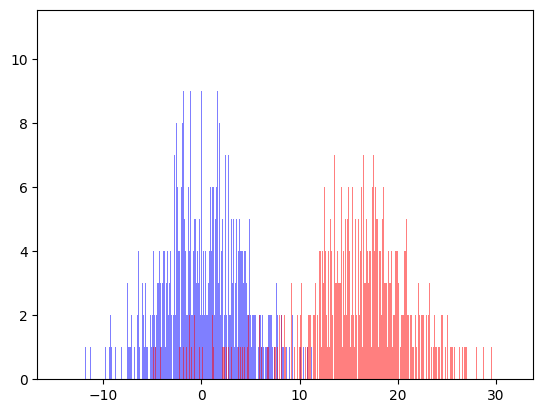

In [289]:
# Call the function to filter values less than the threshold

ng, binsg, pg = plt.hist(Ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
ne, binse, pe = plt.hist(Ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
plt.show()

threshold = thresholds[0]
left_blue = filter_values_less_than_threshold(Ig_new, threshold)
left_red = filter_values_less_than_threshold(Ie_new, threshold)

right_red = filter_values_greater_than_threshold(Ie_new, threshold)
right_blue = filter_values_greater_than_threshold(Ig_new, threshold)


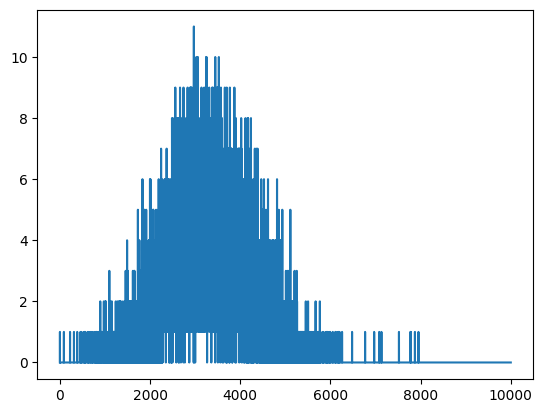

In [300]:
plt.plot(ng)

Define the confusion matrix

In [176]:
# confusion = np.array([
#     [len(left_blue)/(len(left_blue) + len(left_red)), len(left_red)/(len(left_blue) + len(left_red))],
#     [len(right_blue)/(len(right_blue) + len(right_red)), len(right_red)/(len(right_blue) + len(right_red))]
# ])

confusion = np.array([
    [len(left_blue)/(len(left_blue) + len(right_blue)), len(left_red)/(len(left_red) + len(right_red))],
    [len(right_blue)/(len(left_blue) + len(right_blue)), len(right_red)/(len(right_red) + len(left_red))]
])

print('Confusion matrix is:\n', confusion, '\n')

inverse_confusion = np.linalg.inv(confusion)

print('Inverse confusion matrix is:\n', inverse_confusion, '\n')
# print(np.sum(inverse_confusion_normal))


Confusion matrix is:
 [[0.9685 0.0971]
 [0.0315 0.9029]] 

Inverse confusion matrix is:
 [[ 1.03614873 -0.11142988]
 [-0.03614873  1.11142988]] 



Create nxn confusion matrix:

First, create the threshold data

In [314]:
predicted = np.reshape(np.concatenate((np.ones(len(Ig_new)), np.ones(len(Ie_new)))), (-1,1))
predicted_T = np.reshape(predicted, (1,-1))
measured = np.reshape(np.concatenate(((ng), (ne))), (-1,1))
print(np.shape(measured), np.shape(predicted_T ))
M = np.dot(predicted_T, measured)
print(np.shape(M))

(20000, 1) (1, 20000)
(1, 1)


In [229]:
from sklearn.metrics import confusion_matrix
print(len(Ig))
print(len(Ie))

10000
10000


In [235]:
# create a dataset of length Ig_new that is a gaussian centered around the mean of Ig_new

g_gaussian = np.random.normal(np.mean(Ig_new), np.std(Ig_new), len(Ig_new))
e_gaussian = np.random.normal(np.mean(Ie_new), np.std(Ie_new), len(Ie_new))

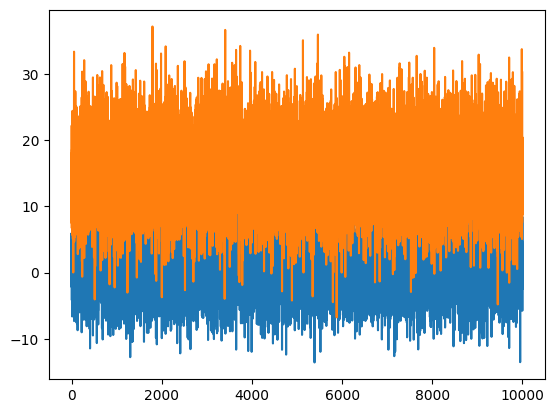

In [238]:
plt.plot(g_gaussian)
plt.plot(e_gaussian)

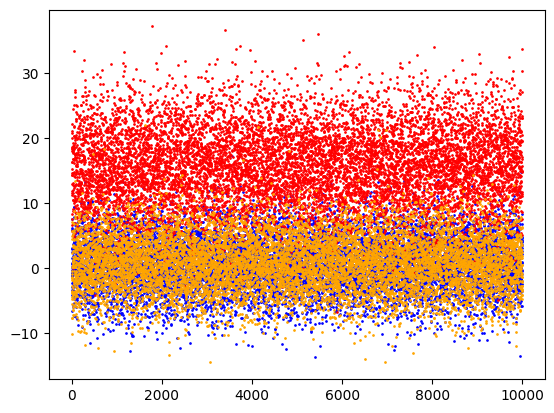

In [253]:
# create an x axis that is the length of y_true
x = np.arange(len(g_gaussian))
plt.scatter(x, g_gaussian, color='b', s = 0.9)
plt.scatter(x, e_gaussian, color='r', s = 0.9)
plt.scatter(x, Ig_new, color='orange', s = 0.9)

In [301]:
# y_true = np.concatenate((g_gaussian, e_gaussian))
g_gaussian = np.random.normal(np.mean(ng), np.std(ng), len(ng))
e_gaussian = np.random.normal(np.mean(ne), np.std(ne), len(ne))
# y_true = np.concatenate((np.ones(len(g_gaussian)), np.ones(len(e_gaussian))))

y_true = np.concatenate((g_gaussian, e_gaussian))
# turn y_meas in a binary array given gaussian shape defined by Ig_new and Ie_new
y_meas = np.concatenate((np.cumsum(ng), np.cumsum(ne)))

# y_meas= np.concatenate((Ig_new, Ie_new))

M = metrics.confusion_matrix(y_meas, y_true)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

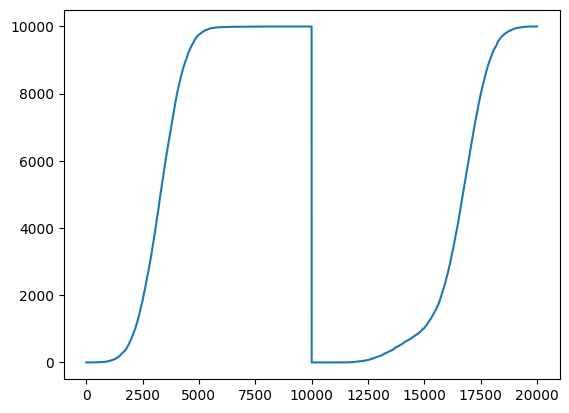

In [292]:
plt.plot(y_meas)

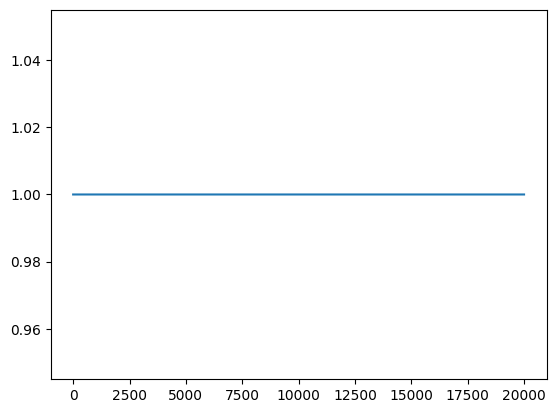

In [299]:
plt.plot(y_true)

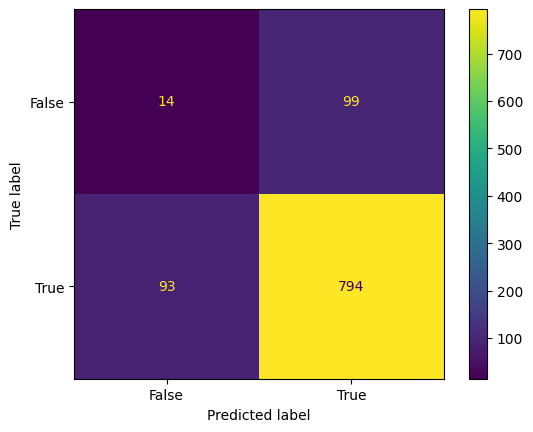

In [297]:

 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()


In [265]:
print(np.dot(M, y_true))

[-10041828.41518515  -5077224.38501351 -13901535.46485825 ...
  60412099.51200076  54268702.94841889  36708337.59140686]


In [ ]:
ng, binsg, pg = axs[1,0].hist(Ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
ne, binse, pe = axs[1,0].hist(Ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)

# create an array that takes the average at of ng at each bin
ng_avg = []
for i in range(len(ng)):
    ng_avg.append((ng[i] + ne[i])/2)
    

In [ ]:

# Define a function to create confusion matrix for a given threshold
def calculate_confusion_matrix(Ig_new, Ie_new, threshold):
    left_blue = filter_values_less_than_threshold(Ig_new, threshold)
    left_red = filter_values_less_than_threshold(Ie_new, threshold)
    right_red = filter_values_greater_than_threshold(Ie_new, threshold)
    right_blue = filter_values_greater_than_threshold(Ig_new, threshold)

    confusion = np.array([
        [len(left_blue)/(len(left_blue) + len(right_blue)), len(left_red)/(len(left_red) + len(right_red))],
        [len(right_blue)/(len(left_blue) + len(right_blue)), len(right_red)/(len(right_red) + len(left_red))]
    ])

    return confusion

# Define a function to create an nxn confusion matrix
def create_nxn_confusion_matrix(Ig_new, Ie_new, thresholds):
    n = len(thresholds)
    confusion_matrix = np.zeros((n, n))

    for i, threshold1 in enumerate(thresholds):
        for j, threshold2 in enumerate(thresholds):
            confusion_matrix[i][j] = np.sum(calculate_confusion_matrix(Ig_new, Ie_new, threshold1) * calculate_confusion_matrix(Ig_new, Ie_new, threshold2))

    return confusion_matrix

# Example usage:
# Define your thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]  # Define your own thresholds here

# Call the function to create the nxn confusion matrix
confusion_matrix = create_nxn_confusion_matrix(Ig_new, Ie_new, thresholds)

print('Confusion matrix is:\n', confusion_matrix)


# Apply the Confusion Matrix to Data

Import the data

In [207]:
# Open the HDF5 file in read mode
filename = "C:\\_Data\\LLqub_contT1\\2024-02-22_00-18-07.h5"
hf = h5py.File(filename, 'r')
# Initialize dictionaries to store datasets
datasets_t1_cont = {}
datasets_t1_recal = {}
# Loop through each group and store datasets in dictionaries
for group_name in hf.keys():
    group = hf[group_name]
    datasets_group = {}
    for dataset_name in group.keys():
        datasets_group[dataset_name] = np.array(group[dataset_name])
    if group_name == 't1_cont':
        datasets_t1_cont = datasets_group
    elif group_name == 't1_recal':
        datasets_t1_recal = datasets_group
# Close the HDF5 file
hf.close()

C:\Users\slab\AppData\Local\Temp\ipykernel_5580\1409307208.py:12: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  datasets_group[dataset_name] = np.array(group[dataset_name])


In [208]:
amp_data =datasets_t1_cont['amp']
q_data = datasets_t1_cont['q']
i_data = datasets_t1_cont['i']
length_array = len(amp_data)


In [209]:
pi_sigma = 0.05889005791993152 # [us]
T1 = 102.81912731303517 #[us]  ## FIX LATER --> MAKE IT THE ACTUAL T1 VALUE GIVEN DATA
readout_length = 15 # [us]
relax_delay = 1500 #[us]

pulse_length = 4*pi_sigma + T1 + readout_length + relax_delay # pulse length [us]
scan_length = length_array * pulse_length *(1E-6) * (1/3600) # length of scan [hr]

print(f'length of pulse {pulse_length} [us]')
print(f'length of scan {scan_length} [hr]')

length of pulse 1618.0546875447149 [us]
length of scan 8.989192708581749 [hr]


Plot the Initial I and Q data 

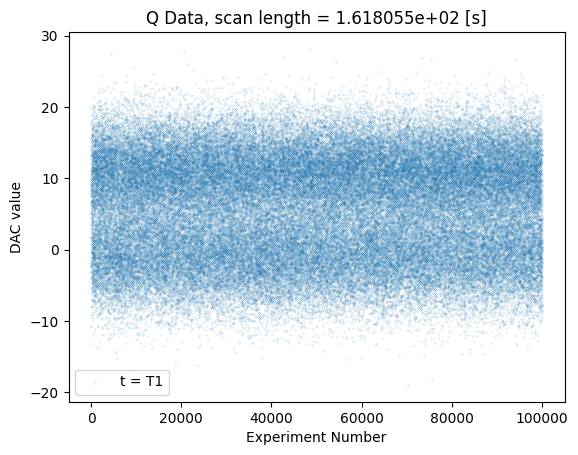

Text(0.5, 1.0, 'I Data, scan length = 1.618055e+02 [s]')

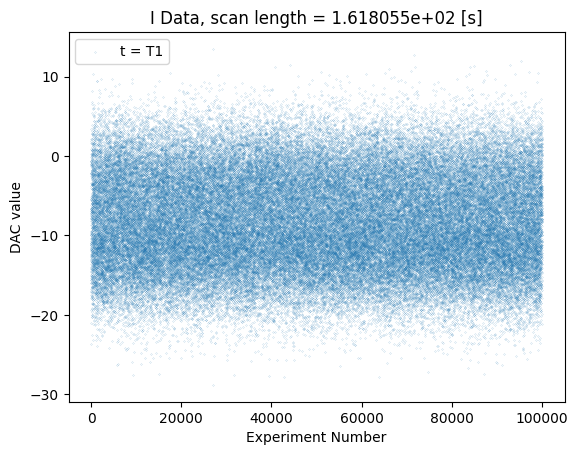

In [210]:
x_data = np.arange(q_data.size)
length_short_scan = 100000
plt.scatter(x_data[0:length_short_scan], q_data[0:length_short_scan], s = 0.009, label = 't = T1')
plt.xlabel('Experiment Number')
plt.ylabel('DAC value')
plt.legend()
plt.title(f'Q Data, scan length = {"{:e}".format(pulse_length*length_short_scan*1E-6)} [s]')
plt.show()
plt.scatter(x_data[0:length_short_scan], i_data[0:length_short_scan], s = 0.009, label = 't = T1')
plt.xlabel('Experiment Number')
plt.ylabel('DAC value')
plt.legend()
plt.title(f'I Data, scan length = {"{:e}".format(pulse_length*length_short_scan*1E-6)} [s]')

First, rotate the data 

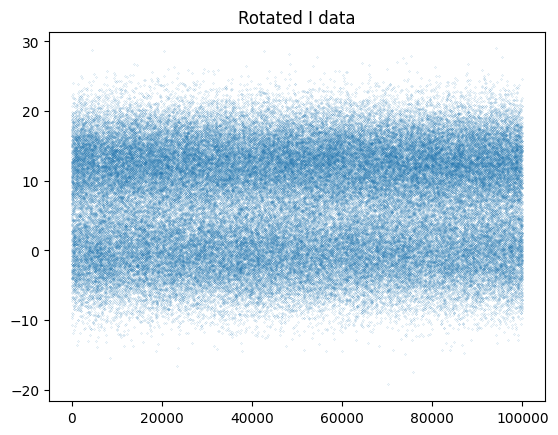

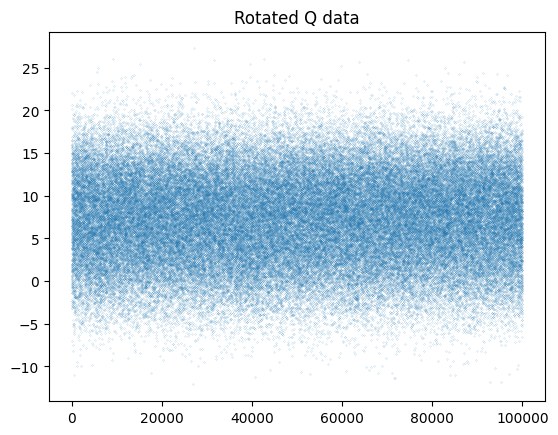

In [211]:
"""Rotate the IQ data"""
original_angle = -7.844325608133489
angle = theta*np.pi/180 + np.pi - (original_angle*np.pi/180)
# angle = 0 + np.pi # data already rotated
I_new = i_data[0:length_short_scan]*np.sin(angle) - q_data[0:length_short_scan]*np.cos(angle)
Q_new = i_data[0:length_short_scan]*np.cos(angle) + q_data[0:length_short_scan]*np.sin(angle)

plt.scatter(x_data[0:length_short_scan], I_new, s = 0.009)
plt.title('Rotated I data')
plt.show()

plt.scatter(x_data[0:length_short_scan], Q_new, s = 0.009)
plt.title('Rotated Q data')
plt.show()

Then, threshold the rotated data 

In [212]:
def filter_values_less_than_threshold(array, threshold):
    indicies = np.where((array) < (threshold))
    values_less_than_threshold = array[indicies]
    
    return values_less_than_threshold, indicies

def filter_values_greater_than_threshold(array, threshold):
    indicies = np.where((array) > (threshold))
    values_greater_than_threshold = array[indicies]
    
    return values_greater_than_threshold, indicies

# Call the function to filter values less than the threshold
threshold = thresholds[0]
# threshold = 5

# I_new = i_data[0:length_short_scan]

I_g, indicies_ig = filter_values_less_than_threshold(I_new, threshold )
I_e, indicies_ie = filter_values_greater_than_threshold(I_new, threshold )


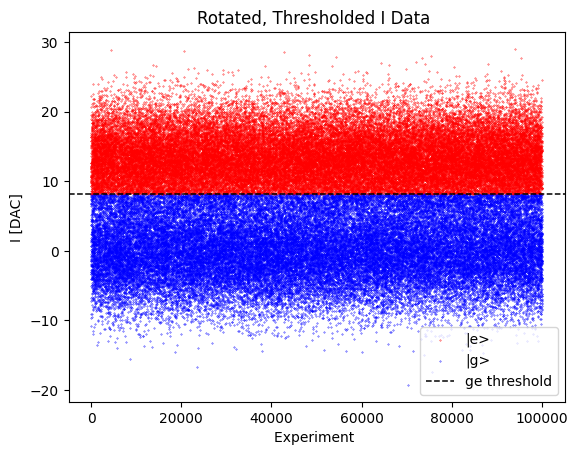

In [213]:
plt.scatter(x_data[indicies_ie], I_e, s= 0.09, color = 'red', label = '|e>')
plt.scatter(x_data[indicies_ig], I_g, s= 0.09, color = 'blue', label = '|g>')
plt.axhline(threshold, color = 'black', linestyle = '--', label = 'ge threshold', linewidth = 1.1)
plt.xlabel('Experiment ')
plt.ylabel('I [DAC]')
plt.legend()
plt.title('Rotated, Thresholded I Data ')
plt.show()


Apply the confusion matrix to the rotated data 

In [214]:
measured_ge = np.array([len(I_g), len(I_e)]).reshape(-1, 1)
print(f'Measured in |g>: {measured_ge[0][0]}\nMeasured in|e>: {measured_ge[1][0]}\n')
print(f'Total number of shots: {np.sum(measured_ge)}', '\n')
# print('Inverse Confusion Matrix\n', inverse_confusion, '\n')

corrected_ge = np.dot((inverse_confusion), measured_ge)
scaled_corrected_ge = corrected_ge * np.sum(measured_ge) / np.sum(corrected_ge)

print(f'Corrected in |g>: {np.round(scaled_corrected_ge[0][0]):.0f}\nCorrected in |e>: {np.round(scaled_corrected_ge[1][0]):.0f}\n')

# print(f'Total number of shots after correction: {np.sum(np.round(scaled_corrected_ge)):.0f}')


Measured in |g>: 49559
Measured in|e>: 50441

Total number of shots: 100000 

Corrected in |g>: 45730
Corrected in |e>: 54270



In [185]:
percent_ground = ((scaled_corrected_ge[0])/(length_short_scan))*100
percent_excited = ((scaled_corrected_ge[1])/(length_short_scan))*100

print(f'Percent in |e> at t = T1: {percent_excited[0]:.1f}%')
print(f'Percent in |g> at t = T1: {percent_ground[0]:.1f}%')


Percent in |e> at t = T1: 54.3%
Percent in |g> at t = T1: 45.7%


## Histogram the |g> and |e> Blobs

The corrected |g> and |e> blobs from the confusion matrix. 

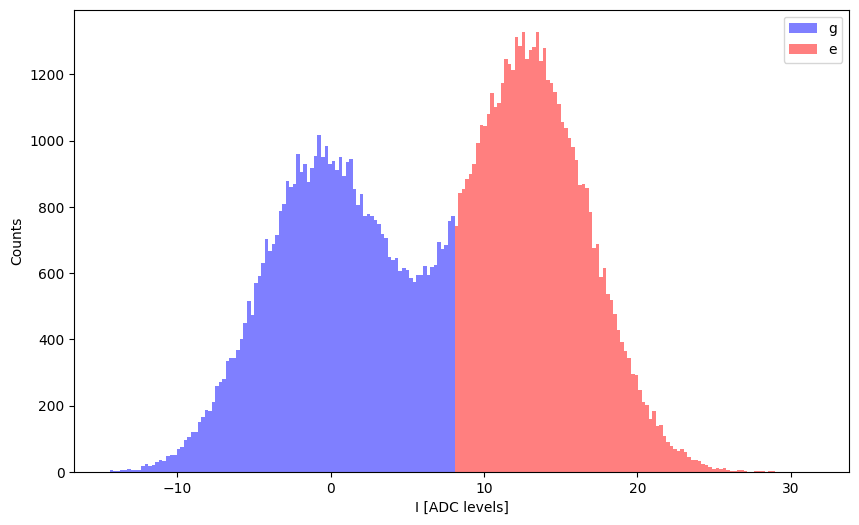

In [186]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))


ng, binsg, pg = axs.hist(I_g, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
ne, binse, pe = axs.hist(I_e, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)



axs.set_ylabel('Counts')
axs.set_xlabel('I [ADC levels]')       
axs.legend(loc='upper right')

plt.show()

In [187]:
print(np.shape(I_g))

(49559,)


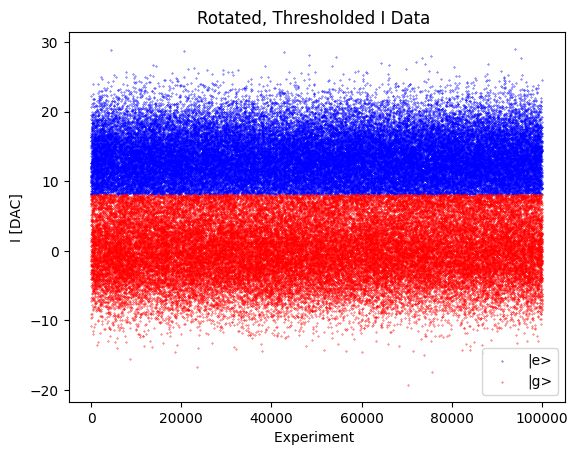

In [188]:
plt.scatter(x_data[indicies_ie], I_e, s= 0.09, color ='blue', label = '|e>')
plt.scatter(x_data[indicies_ig], I_g, s= 0.09,color = 'red', label = '|g>')
plt.xlabel('Experiment ')
plt.ylabel('I [DAC]')
plt.legend()
plt.title('Rotated, Thresholded I Data ')
plt.show()


e amplitude: 0.04422580687138498 
e center: 7.2215495568635655 
e width: 196.96846211617068 
g amplitude: -0.0073668436440291595 
g center: -11.245793243534472 
g width: 15.577358770865468


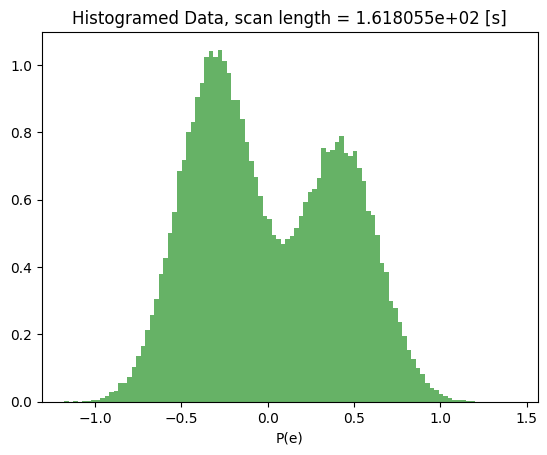

Text(0, 0.5, 'P(e)')

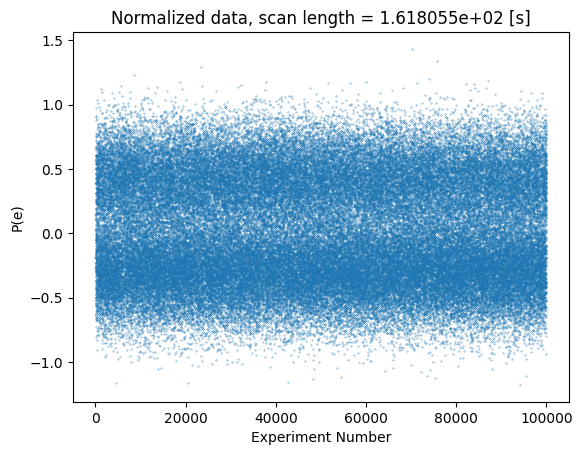

In [189]:

guess = [ 0.01, 0, 2, 0.04, -18, 2]


# Define the Gaussian function
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / wid)

# Define the sum of two Gaussian functions
def two_gaussians(x, amp1, cen1, wid1, amp2, cen2, wid2):
    return gaussian(x, amp1, cen1, wid1) + gaussian(x, amp2, cen2, wid2)

# Your data
d = I_new[0:length_short_scan]

# Create the histogram data
hist, bin_edges = np.histogram(d, bins=300, density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2


# Fit the histogram data to the sum of two Gaussian functions
params, params_covariance = curve_fit(two_gaussians, bin_centres, hist, p0=guess)

# Print the parameters
#[g amplitude, g center, g width, e amplitude, e center, e width]
print('e amplitude:',params[0],'\ne center:',params[1],'\ne width:',params[2], '\ng amplitude:', params[3],'\ng center:',params[4],'\ng width:',params[5], )

x_fit = np.linspace(bin_edges[0], bin_edges[-1], length_short_scan)
y_fit = two_gaussians(x_fit, *params)

# Plot the histogram and the fitted function
# plt.hist(d, bins=100, density=True, alpha=0.6, color='g')
# plt.plot(x_fit, y_fit, 'r-')
# plt.axvline(x = params[1], color = 'r', label = 'e' )
# plt.axvline(x = params[4], color = 'b', label = 'g')
# plt.legend()
# plt.show()

dnorm = 1- (d - params[4])/(params[1]-params[4])
plt.hist(dnorm, bins=100, density=True, alpha=0.6, color='g')
plt.title(f'Histogramed Data, scan length = {"{:e}".format(pulse_length*length_short_scan*1E-6)} [s]')
# plt.plot(x_fit, y_fit, 'r-')
# plt.axvline(x = params[1], color = 'r', label = 'e' )
# plt.axvline(x = params[4], color = 'b', label = 'g')
# plt.legend()
plt.xlabel('P(e)')
plt.show()

plt.plot(dnorm,'.', markersize=0.5)
plt.title(f'Normalized data, scan length = {"{:e}".format(pulse_length*length_short_scan*1E-6)} [s]')
plt.xlabel('Experiment Number')
plt.ylabel('P(e)')


Text(0.5, 1.0, 'P(e) at t = T1')

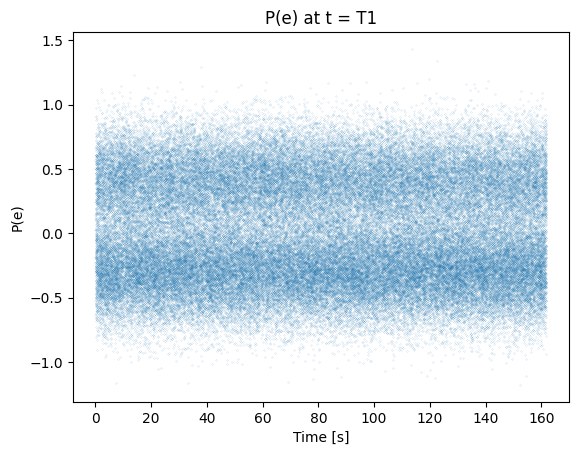

In [190]:
time_axis = x_data[0:length_short_scan] * pulse_length*1E-6 
plt.scatter(time_axis, dnorm, s = 0.005)
plt.xlabel('Time [s]')
plt.ylabel('P(e)')
plt.title('P(e) at t = T1')

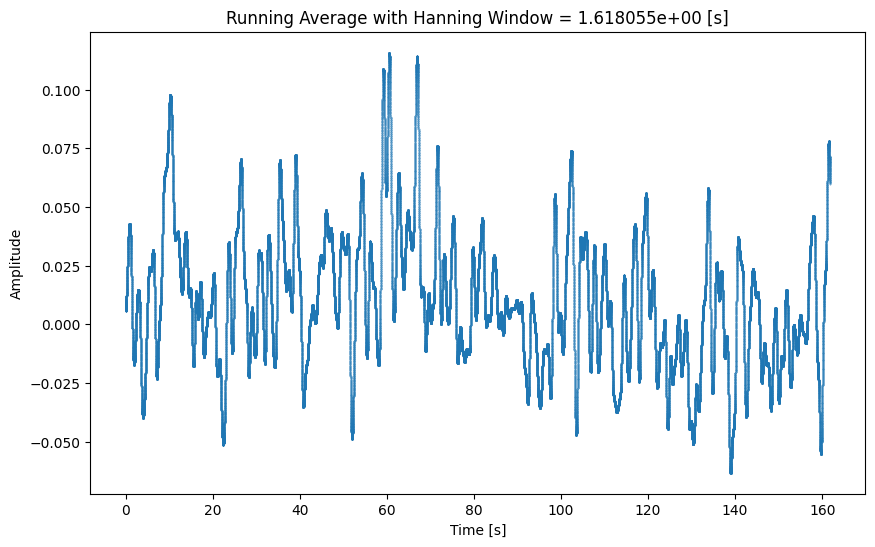

In [191]:
window_size = 1000
hanning_window = np.hanning(window_size) / np.sum(np.hanning(window_size))  # Normalize the window

# Apply running average using convolution
y_data_smoothed = np.convolve(dnorm, hanning_window, mode='same')

# Plot the original and smoothed data
plt.figure(figsize=(10, 6))
plt.plot(time_axis, y_data_smoothed,'.', markersize=0.5)
plt.xlabel('Time [s]')

plt.title(f'Running Average with Hanning Window = {"{:e}".format(window_size*pulse_length*1E-6)} [s]')
plt.ylabel('Amplitude')
# plt.legend()
plt.show()

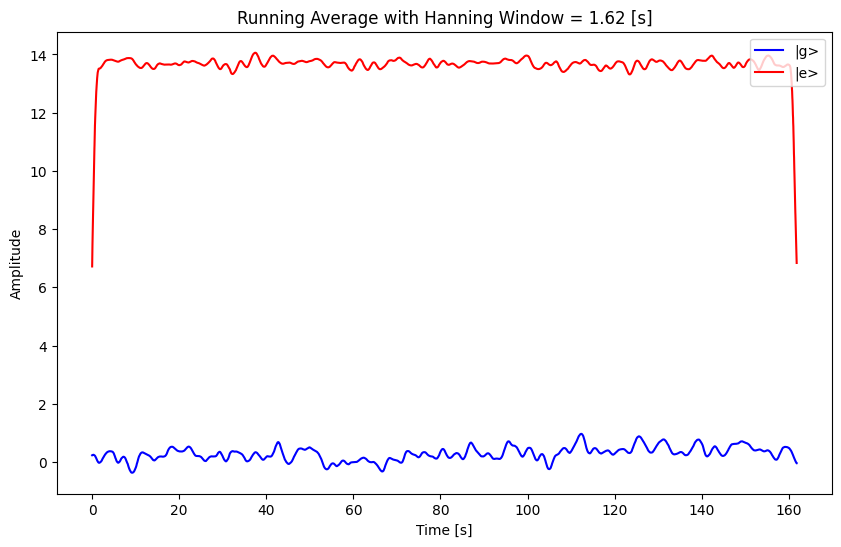

In [192]:
window_size = 1000
hanning_window = np.hanning(window_size) / np.sum(np.hanning(window_size))  # Normalize the window

# Apply running average using convolution
y_data_smoothed = np.convolve(I_g, hanning_window, mode='same')

# Plot the original and smoothed data
plt.figure(figsize=(10, 6))
plt.plot(time_axis[indicies_ig], y_data_smoothed,label = '|g>', color = 'blue')
plt.title(f'Running Average with Hanning Window = {"{:e}".format(window_size*pulse_length*1E-6)} [s]')

# Apply running average using convolution
y_data_smoothed = np.convolve(I_e, hanning_window, mode='same')

# Plot the original and smoothed data
plt.plot(time_axis[indicies_ie], y_data_smoothed, label = '|e>', color = 'red')

# plt.title(f'Running Average with Hanning Window = {"{:e}".format(window_size*pulse_length*1E-6)} [s]')
plt.title(f'Running Average with Hanning Window = {(window_size*pulse_length*1E-6):.2f} [s]')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend( loc = 'upper right')
plt.show()

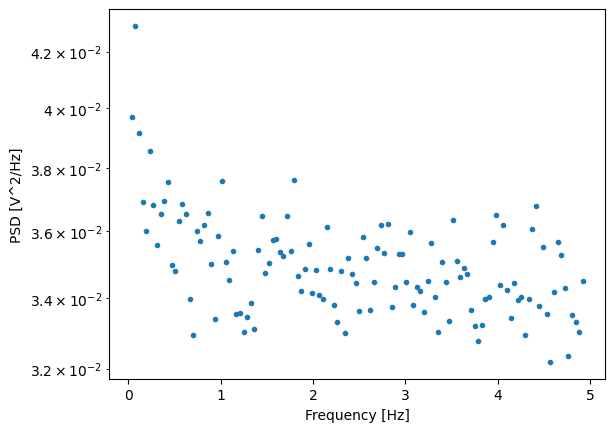

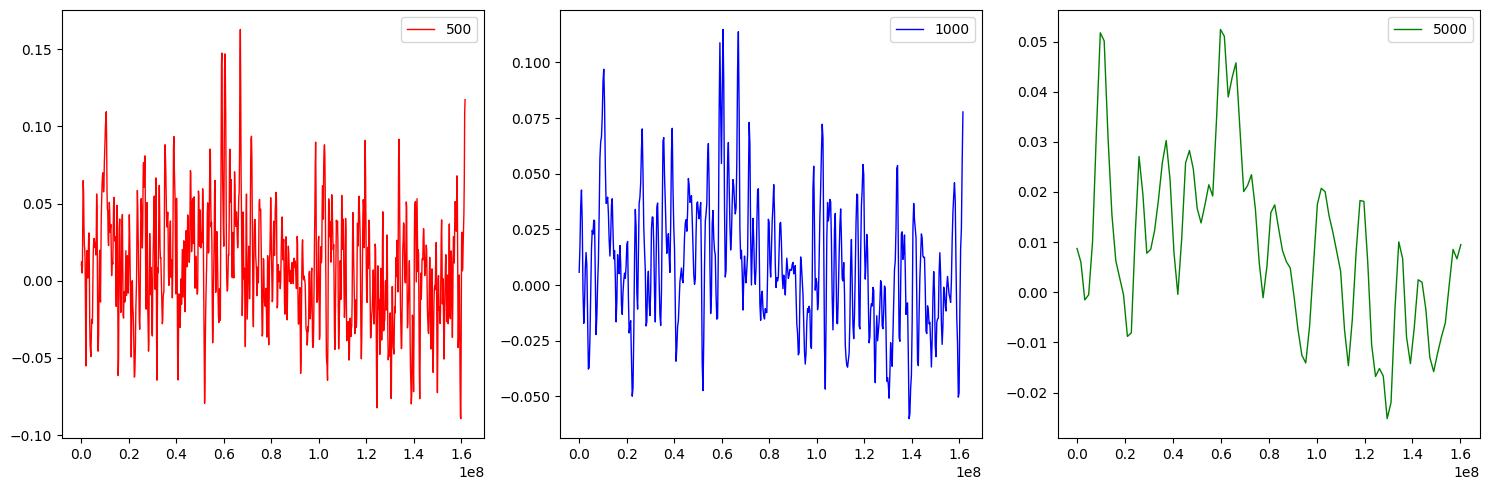

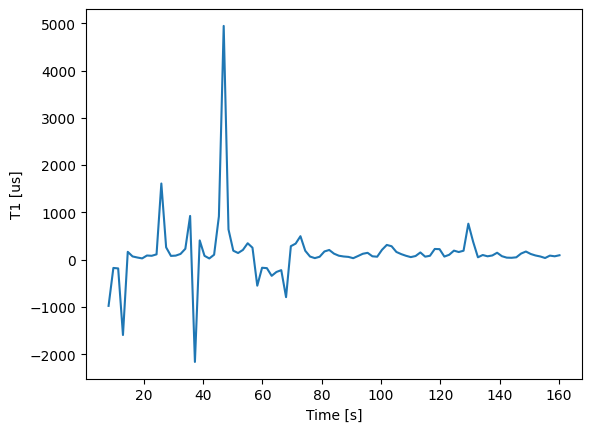

646.100147015506


In [193]:
# Compute the power spectral density of dnorm
# fs is sampling frequency, inverse of pulse period
frequencies, psd = welch(dnorm, fs=10)

# Plot the power spectral density
plt.semilogy(frequencies[1:-2], psd[1:-2],'.')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.show()

# %%
def hanning(y, window_size=1000):
    hanning_window = np.hanning(window_size) / np.sum(np.hanning(window_size))  # Normalize the window

    # Apply running average using convolution
    return np.convolve(y, hanning_window, mode='same')

def decimate(y, factor=100):
    return y[::factor]

def filt_data(y, T, window): 
    yfilt = decimate(hanning(y, window), int(window/5))
    tfilt = np.arange(len(yfilt))*T*np.ceil(window/5)
    return tfilt, yfilt

T=pulse_length # gives correction time in us 

filt5k = filt_data(dnorm, T, 5000)
filt1k = filt_data(dnorm, T, 1000)
filt500 = filt_data(dnorm, T, 500)

# put each plot as its own subplot 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(filt500[0], filt500[1], linewidth=1, label = '500', color = 'red')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(filt1k[0], filt1k[1], linewidth=1, label = '1000', color = 'blue')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(filt5k[0], filt5k[1], linewidth=1, label = '5000', color = 'green')
plt.legend()
plt.tight_layout()
plt.show()


# Convert to T1 
skip = 5
logA = np.mean(np.log(abs(filt5k[1])))+1  # This tries to esimate the impact of imperfect prep 
T1_norm_corr = 1/(logA - np.log(abs(filt5k[1]))) # Correcting for imperfect prep 
T1_norm_corr = T1_norm_corr*T1
T1_norm = - 1/np.log(abs(filt5k[1])) # Not corrected 
new_time = filt5k[0] * 1E-6 
plt.plot(new_time[skip:] , T1_norm_corr[skip:])
plt.ylabel('T1 [us]')
plt.xlabel('Time [s]')
plt.show()

# %% Check standard deviation normalized to T1
print(np.std(T1_norm_corr[5:])) 




In [ ]:
plt.plot()

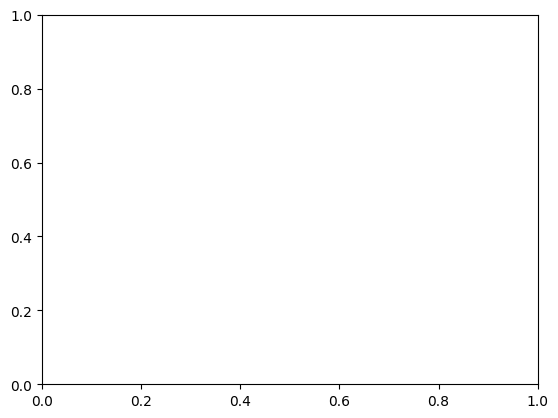

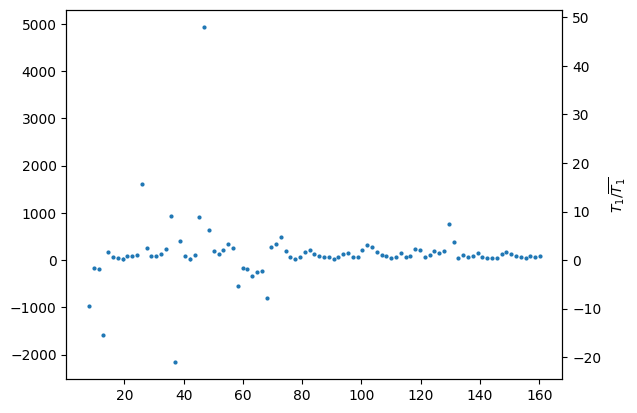

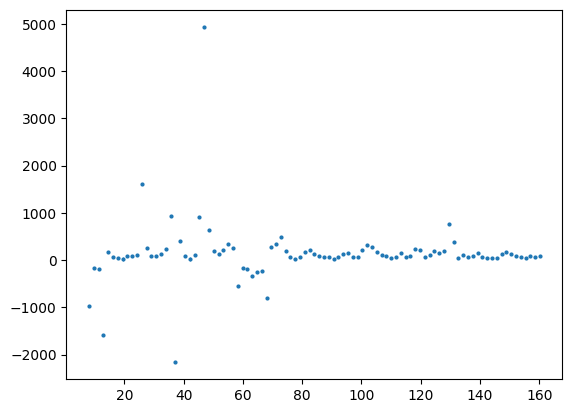

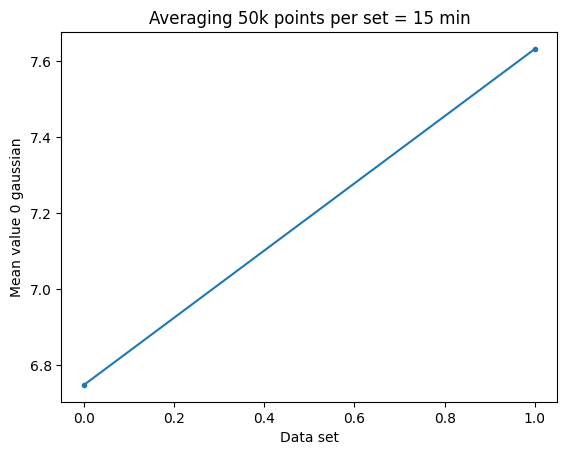

Text(0.5, 1.0, 'Averaging 50k points per set = 15 min')

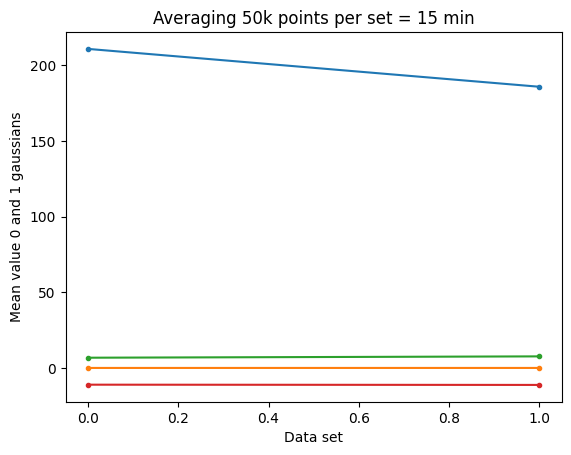

In [195]:
# %% Add second axis, error bar
logA = np.mean(np.log(abs(filt5k[1])))+1  # This tries to esimate the impact of imperfect prep 
def error_prop(x, a): return 1/x/(a+np.log(x)**2)

err = error_prop(abs(filt5k[1]), logA)

fig, ax1 = plt.subplots()
T1_norm = - 1/np.log(abs(filt5k[1])) # Not corrected 
fig, ax1 = plt.subplots()

ax1.errorbar(new_time[skip:], T1_norm_corr[skip:], yerr=err[skip:], fmt='o', markersize=2, elinewidth= 0.5, label = 'T1')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('$T_1/\overline{T_1}$')
plot_lim=ax1.get_ylim()
ax2.set_ylim(plot_lim[0]/T1, plot_lim[1]/T1)
plt.show()

plt.figure()
plt.errorbar(new_time[skip:], T1_norm_corr[skip:], yerr=err[skip:], fmt='o', markersize=2, elinewidth= 0.5, label = 'T1')
#########
npoints = length_short_scan
avg_points =5e4

param_array=np.array([]).reshape(0,6)
for i in range(int(npoints/avg_points)):
    d = I_new[i*int(avg_points):(i+1)*int(avg_points)]
    # Create the histogram data
    hist, bin_edges = np.histogram(d, bins=100, density=True)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit the histogram data to the sum of two Gaussian functions
    params, params_covariance = curve_fit(two_gaussians, bin_centres, hist, p0=guess)

    # Print the parameters
    param_array=np.vstack((param_array,params))

plt.figure()
plt.plot(param_array[:,1],'.-')
plt.xlabel('Data set')
plt.ylabel('Mean value 0 gaussian')
plt.title('Averaging 50k points per set = 15 min')
plt.show()
# plt.savefig('mean_gaussian0_v2.png')

plt.figure()
plt.plot(param_array[:,2],'.-')
plt.plot(param_array[:,3],'.-')
plt.plot(param_array[:,1],'.-')
plt.plot(param_array[:,4],'.-')
plt.xlabel('Data set')
plt.ylabel('Mean value 0 and 1 gaussians')
plt.title('Averaging 50k points per set = 15 min')
# plt.savefig('mean_gaussian01_v2.png')




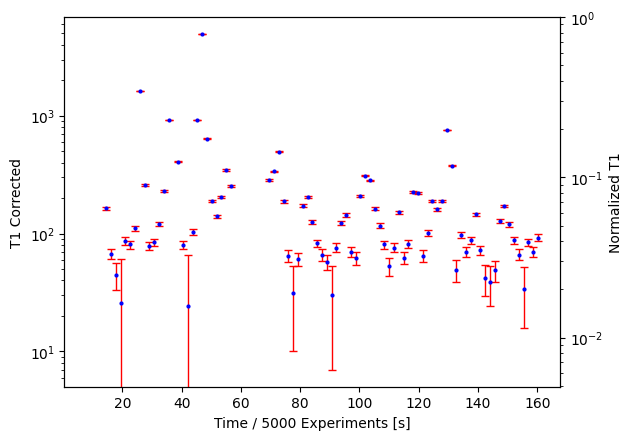

In [247]:
fig, ax1 = plt.subplots()

# Plotting the data with the first y-axis
ax1.errorbar(new_time[skip:], (T1_norm_corr[skip:]), yerr=err[skip:], fmt='o', markersize=2, elinewidth=1, ecolor='red', color='blue', label='Error', capsize=3)
ax1.set_xlabel('Time / 5000 Experiments [s]')
ax1.set_ylabel('T1 Corrected', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_ylabel('Normalized T1', color='black')  # Label for the second y-axis
plot_lim = ax1.get_ylim()
ax2.set_ylim(np.min( abs(T1_norm_corr[skip:])/np.max(T1_norm_corr[skip:])), np.max(T1_norm_corr[skip:])/np.max(T1_norm_corr[skip:]))
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_yscale('log')

In [ ]:
plt